In [1]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

In [2]:
g = 9.8
rho0 = 1035.0
radius = 6371e+3

In [3]:
# tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
# tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
tpxo = xr.open_dataset('/g/data/nm03/TPXO9v5a/h_tpxo9.v5a.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO9v5a/gridtpxo9v5a.nc')
amp_tpxo = tpxo.ha.isel({'nc':0}).transpose()
lon_z = np.array(tpgd.lon_z.transpose())/180 *np.pi
lat_z = np.array(tpgd.lat_z.transpose())/180 *np.pi
lon_u = np.array(tpgd.lon_u.transpose())/180 *np.pi
lat_u = np.array(tpgd.lat_u.transpose())/180 *np.pi
lon_v = np.array(tpgd.lon_v.transpose())/180 *np.pi
lat_v = np.array(tpgd.lat_v.transpose())/180 *np.pi
hz_tpxo = np.array(tpgd.hz.transpose())
hu_tpxo = np.array(tpgd.hu.transpose())
hv_tpxo = np.array(tpgd.hv.transpose())
ny, nx  = np.array(tpgd.ny), np.array(tpgd.nx)

0.3.0


In [40]:
lon_xr = tpgd.lon_z.transpose()
np.nanmax(lat_z)

90.00000254077894

### Construct TPXO elevation $\eta$

In [4]:
omega_m2  = np.full((ny.size,nx.size),(2*np.pi/(12.4206014)))
elev_tpxo = np.array(amp_tpxo)

### Construct $\eta_{eq}$ and $\eta_{sal}$

In [5]:
eta_eq = 0.2445 * np.cos(lat_z[:,:])**2 

In [6]:
SAL = xr.open_dataset('/g/data/nm03/OTPSnc/DATA/load_file.nc')
eta_sal = np.array(SAL.ha.isel({'nc':0}).transpose())

In [7]:
eta = eta_sal + eta_eq

In [8]:
# tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO/u_tpxo9.v1.nc')
tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO9v5a/u_tpxo9.v5a.nc')
u_tpxo = np.array(tpxo_vel.ua.isel({'nc':0}).transpose()/100) * hu_tpxo
v_tpxo = np.array(tpxo_vel.va.isel({'nc':0}).transpose()/100) * hv_tpxo

### Interp eta to u and v points

In [9]:
start_time = time.time()

ds_elev_z = xr.Dataset(data_vars={"elev": (('ny','nx'), elev_tpxo),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z), 
                               "lat": (('ny', 'nx'), lat_z)})
ds_grid_u = xr.Dataset({"lat": (["ny","nx"], lat_u),
                        "lon": (["ny","nx"], lon_u)})
ds_grid_v = xr.Dataset({"lat": (["ny","nx"], lat_v),
                        "lon": (["ny","nx"], lon_v)})

regridder_z2u = xe.Regridder(ds_elev_z, ds_grid_u, "bilinear", extrap_method="inverse_dist")
regridder_z2v = xe.Regridder(ds_elev_z, ds_grid_v, "bilinear", extrap_method="inverse_dist")

ds_elev_u = regridder_z2u(ds_elev_z)
ds_elev_v = regridder_z2v(ds_elev_z)

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

Execution time: 177.0 seconds! 



In [10]:
elev_u = np.array(ds_elev_u["elev"])
elev_v = np.array(ds_elev_v["elev"])

In [11]:
# interp from v-mid-lat to z points
divP1 = 1/( radius*np.cos(lat_z[1:,:]) ) * \
(v_tpxo[1:,:]*elev_v[1:,:]*np.cos(lat_v[1:,:]) - v_tpxo[:-1,:]*elev_v[:-1,:]*np.cos(lat_v[:-1,:])) / (lat_v[1:,:] - lat_v[:-1,:])
# interp from u-mid-lon to z points
divP2 = 1/( radius*np.cos(lat_z[:,:-1]) ) * \
( u_tpxo[:,1:]*elev_u[:,1:] - u_tpxo[:,:-1]*elev_u[:,:-1] ) / (lon_u[:,1:] - lon_u[:,:-1])       

In [12]:
start_time = time.time()

ds_divP_v = xr.Dataset(data_vars={"divP1": (('ny','nx'), divP1),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z[1:,:]), 
                               "lat": (('ny', 'nx'), lat_z[1:,:])})

ds_divP_u = xr.Dataset(data_vars={"divP2": (('ny','nx'), divP2),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z[:,:-1]), 
                               "lat": (('ny', 'nx'), lat_z[:,:-1])})

ds_grid_z = xr.Dataset({"lat": (["ny","nx"], lat_z),
                        "lon": (["ny","nx"], lon_z)})

regridder_div_v2z = xe.Regridder(ds_divP_v, ds_grid_z, "bilinear", extrap_method="inverse_dist")
regridder_div_u2z = xe.Regridder(ds_divP_u, ds_grid_z, "bilinear", extrap_method="inverse_dist")

ds_divP1_z = regridder_div_v2z(ds_divP_v)
ds_divP2_z = regridder_div_u2z(ds_divP_u)

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

Execution time: 147.5 seconds! 



In [13]:
P = g * rho0 * (ds_divP1_z["divP1"] + ds_divP2_z["divP2"]) 

In [14]:
grad_the = v_tpxo[:-1,:] /radius * (eta[1:,:]-eta[:-1,:]) /(lat_z[1:,:]-lat_z[:-1,:])
grad_phi = u_tpxo[:,1:] /(radius * np.cos(lat_u[:,1:])) * (eta[:,1:]-eta[:,:-1]) / (lon_z[:,1:]-lon_z[:,:-1])

In [15]:
start_time = time.time()

ds_grad_the = xr.Dataset(data_vars={"grad_the": (('ny','nx'), grad_the),
                                },
                      coords={"lon": (('ny', 'nx'), lon_v[:-1,:]), 
                              "lat": (('ny', 'nx'), lat_v[:-1,:])})

ds_grad_phi = xr.Dataset(data_vars={"grad_phi": (('ny','nx'), grad_phi),
                                },
                      coords={"lon": (('ny', 'nx'), lon_u[:,1:]), 
                              "lat": (('ny', 'nx'), lat_u[:,1:])})

ds_grid_z = xr.Dataset({"lat": (["ny","nx"], lat_z),
                        "lon": (["ny","nx"], lon_z)})

regridder_grad_the_2z = xe.Regridder(ds_grad_the, ds_grid_z, "bilinear", extrap_method="inverse_dist")
regridder_grad_phi_2z = xe.Regridder(ds_grad_phi, ds_grid_z, "bilinear", extrap_method="inverse_dist")

ds_grad_the_z = regridder_grad_the_2z(ds_grad_the)
ds_grad_phi_z = regridder_grad_phi_2z(ds_grad_phi)

grad_the_z = np.array(ds_grad_the_z["grad_the"])
grad_phi_z = np.array(ds_grad_phi_z["grad_phi"])

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

Execution time: 178.1 seconds! 



In [16]:
W = g * rho0 * (grad_the_z + grad_phi_z)

In [17]:
D = np.array(W - P)

In [35]:
np.nanmean(D)

-23.210100812369063

In [18]:
ds_dissip = xr.Dataset(data_vars={"TPXO_dissip": (('ny','nx'), D),
                                 },
                       coords={"lon": (('ny', 'nx'), np.rad2deg(lon_z)), 
                               "lat": (('ny', 'nx'), np.rad2deg(lat_z))})

In [19]:
dlat = np.full((ny.size,nx.size),np.nan) 
dlon = np.full((ny.size,nx.size),np.nan)
for j in range(ny.size):
    for i in range(nx.size):
        dlat[:,i] = np.squeeze(lat_u[:,i] - lat_v[:,i])*2
        dlon[j,:] = np.squeeze(lon_v[j,:] - lon_u[j,:])*2

In [20]:
dA = radius**2 * np.cos(lat_z) * dlat * dlon

In [32]:
hz_tpxo = tpgd.hz.transpose()
lat_z = tpgd.lat_z.transpose()

mask = xr.where(hz_tpxo > 500, 1, np.nan)
fac_dep = xr.where(hz_tpxo > 1000, 1, np.nan) 
fac_lat = xr.where((lat_z < 75) & (lat_z > -75), 1, np.nan)
dA_fac = dA * fac_lat
TPXO_dissip   = -np.array(ds_dissip["TPXO_dissip"]) *np.array(fac_lat) * mask
global_dissip = np.nansum(TPXO_dissip *dA_fac) /1e+12
deep_dissip   = np.nansum(TPXO_dissip *dA_fac *np.array(fac_dep)) /1e+12
print('Global M2 tidal energy dissipation: %.4fTW'%global_dissip)
print('Open ocean M2 tidal energy dissipation: %.4fTW'%deep_dissip)
print('Open ocean dissipation fraction: %d%%'%(deep_dissip/global_dissip*100))

Global M2 tidal energy dissipation: 3.0139TW
Open ocean M2 tidal energy dissipation: 3.5325TW
Open ocean dissipation fraction: 117%


In [31]:
dA_fac = dA * fac_lat
np.nanmax(dA_fac)

343453122.4957199

In [22]:
depth = tpgd.hz.transpose()
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
lat_z_deg = np.array(tpgd.lat_z.transpose())
lon_z_deg = np.array(tpgd.lon_z.transpose())

depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_z_deg),
                              'lat': (('yh', 'xh'), lat_z_deg)})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

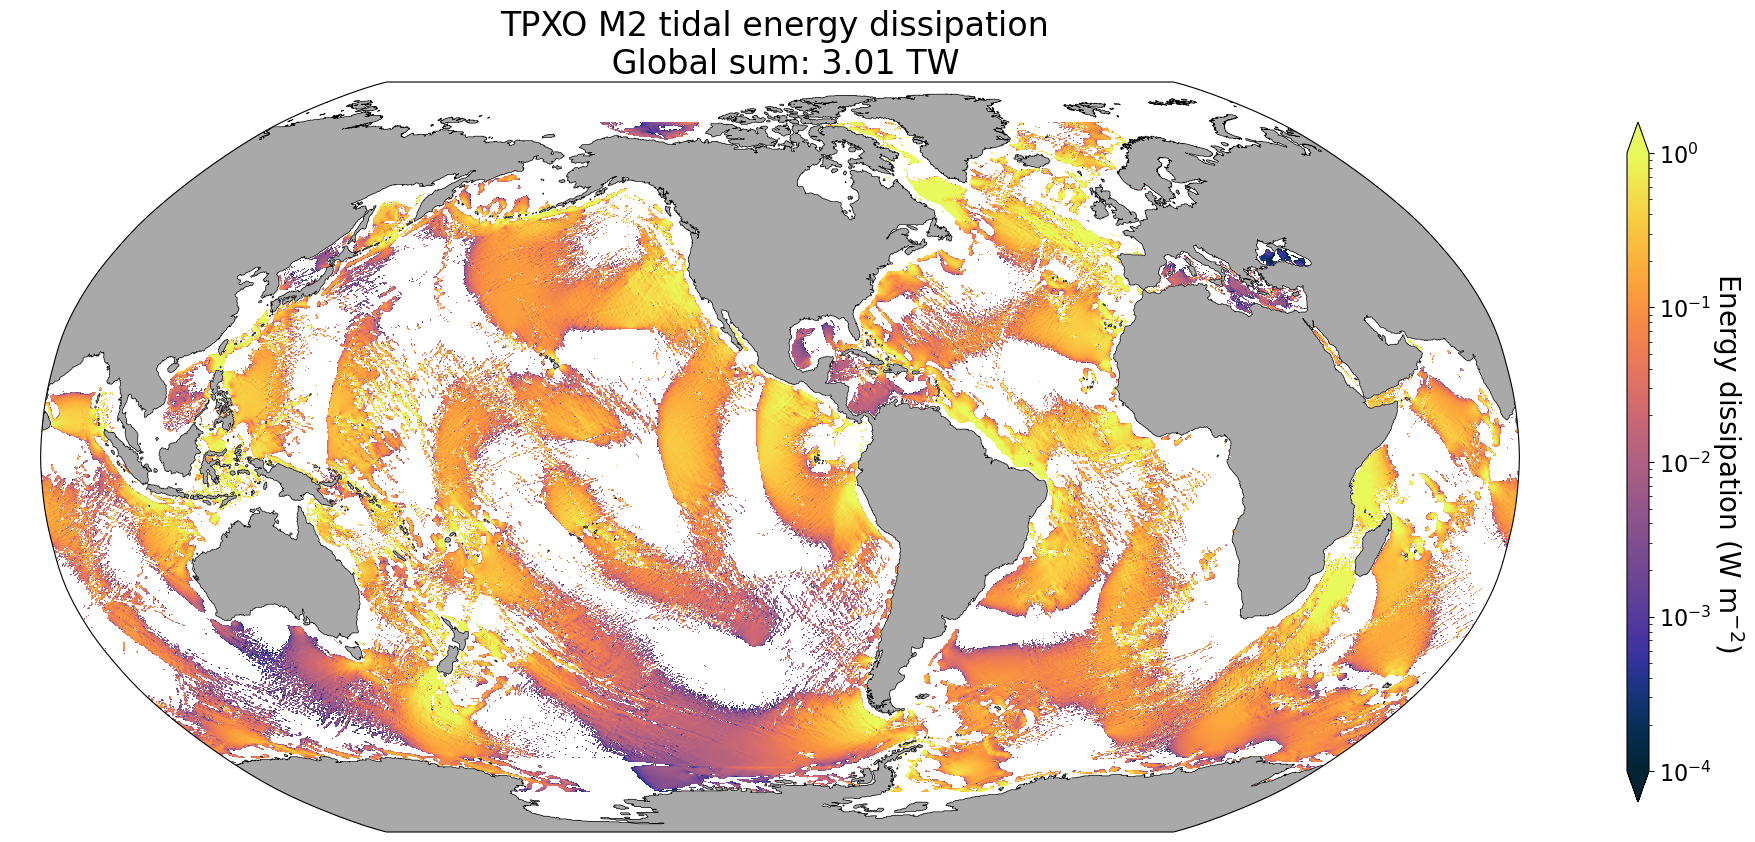

In [41]:
varlist = ['TPXO_dissip']
title   = ['TPXO M2 tidal energy dissipation \n Global sum: %.2f TW'%(global_dissip)]
tick_locs = np.array([1e-4,1e-3,1e-2,1e-1,1e-0])
tick_labels = np.array(["10$^{-4}$","10$^{-3}$","10$^{-2}$","10$^{-1}$","10$^{0}$"])
# tick_locs = np.array([-0.01,-0.005,0,0.005,0.01])
# tick_labels = np.array(["-0.01","-.005","0","0.005","0.01"])

fig = plt.figure(figsize=(22, 10))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

    # p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=-0.01, vmax=0.01)
    p1 = ax.pcolormesh(lon_z_deg, lat_z_deg, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, norm=LogNorm(vmin=1e-4, vmax=1e+0))
    plt.title(title[I],fontsize=24)
  
    if I==0:
        ax_cb = plt.axes([0.86, 0.13, 0.01, 0.68])
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy dissipation (W m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    if I==0:
        ax.set_position([0.1,0.1,0.75,0.75])
        
plt.savefig('/g/data/nm03/lxy581/exps_figs/TPXO_M2_dissip_log.png', dpi=100, bbox_inches='tight')